This notebook relies primarily on 
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

for faster GPU computation facilitated by Tensorflow. Have no option other than this for fast computation

This notebook recustomises dataset, input, output for model. It also adds a level of customization in the architecture.

Just add extra class_weight for training to get small-bert class_weights

To load models:
normal version: best_path = best/best_model/best.ckpt

classweight version: best_path = small_bert/class_weights/best.ckpt


## Setup


In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tenso

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [2]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [3]:
# !pip3 install tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
from google.colab import drive 
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Bookpred/Assignment 2"
%cd {path}
!ls

Mounted at /content/drive
/content/drive/My Drive/Bookpred/Assignment 2
 8.prep_IMDB.ipynb
'Assignment 2 Track.gdoc'
 bert
 best_model
 book_rating_test.csv
 book_rating_train.csv
 book_text_features_countvec
 book_text_features_doc2vec
 book_text_features_tfidf
 COMP30027_Project2_spec_2023S1.pdf
'Copy of model.png'
 English
'English (1)'
'Feature engineering.ipynb'
 full_dataset
 history.pkl
 history_v.pkl
 lgbm_class_weight.joblib
 lgbm_cv.joblib
 lgbm_cw.joblib
 lgbm_normal.joblib
 lgbm_oversampling.joblib
 matrix.npz
 Model.ipynb
 model.png
 multilingual_best
 multilingual_epochs
 output.csv
 Oversampling
 Oversampling_real
 partition
 random_forest_doc.joblib
 random_forest.joblib
 random_forest_num.joblib
 rf_cw.joblib
 rf_normal.joblib
 rf_smote.joblib
 small_bert
 smallbert_class_weight.png
 smallbert_focal.png
 smallbert_normal.png
 smallbert_oversampling_minority.png
 Test
 test_focal.npy
 text_features_description.ipynb
 train_ind.pkl
 Validation
 val_ind.pkl
 val_output_sm

In [6]:
import pandas as pd
train_df = pd.read_csv("book_rating_train.csv")
train_df

test_df = pd.read_csv("book_rating_test.csv")
test_df


train_dir = "/content/drive/MyDrive/Bookpred/Assignment 2/English"
os.listdir(train_dir)

['4.0', '3.0', '5.0']

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)


val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)


test_ds = tf.keras.utils.text_dataset_from_directory(
    "/content/drive/MyDrive/Bookpred/Assignment 2/Test", labels = None, label_mode =None, batch_size = batch_size, seed = seed, shuffle = False
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 23011 files belonging to 3 classes.
Using 18409 files for training.
Found 23011 files belonging to 3 classes.
Using 4602 files for validation.
Found 5766 files belonging to 1 classes.


Let's take a look at a few reviews.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'""I can assure you," said the young man, "that it will take a very tangible ghost to frighten me.""So says the foolishly brave narrator of H. G. Wells\'s "The Red Room," one of the thirteen great ghost stories gathered together in this deluxe illustrated volume. Selected and illustrated by Barry Moser, a master of the macabre, these spooky tales will send a shiver down the spine of even the bravest reader.This new edition includes classic masterpieces of horror by H. P. Lovecraft, Brain Stoker, Richard Middleton, and Arthur Conan Doyle. There are also several chilling modern tales of the supernatural by such authors as Madeleine L\'Engle and Joyce Carol Oates to petrify even the most seasoned explorer of the dark realms.From the slowly gathering dread of being caught in the grips of a haunted house to the sure, sharp horror of realization that overcomes one entering the spirit world, nothing compares to the thrill of these tales from the great beyond. With Barry Moser\'s four

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [9]:
# max_length = 512
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model


In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611872  0.36673853  0.1523371   0.65504426
  0.9681154  -0.94862705  0.00216182 -0.9877732   0.06842728 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.34321266  0.33231518 ...  0.21300897  0.71020764
  -0.05771176]
 [-0.2874206   0.3198098  -0.23018597 ...  0.5845501  -0.21329726
   0.72692066]
 [-0.6615712   0.68876785 -0.8743292  ...  0.10877268 -0.2617322
   0.4785534 ]
 ...
 [-0.22561154 -0.28925663 -0.07064398 ...  0.47566003  0.8327717
   0.40025344]
 [-0.29824272 -0.27473173 -0.05450511 ...  0.48849759  1.0955356
   0.18163322]
 [-0.44378266  0.00930682  0.07223728 ...  0.17290092  1.1833241
   0.07898061]]


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# def build_classifier_model():
#   text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#   preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#   tokenize = hub.KerasLayer(preprocessor.tokenize)
#   tokenized_inputs = [tokenize(segment) for segment in text_inputs]

#   seq_length = 256  # Your choice here.
#   bert_pack_inputs = hub.KerasLayer(
#     preprocessor.bert_pack_inputs,
#     arguments=dict(seq_length=seq_length), name = 'preprocessing')  # Optional argument.
#   encoder_inputs = bert_pack_inputs(tokenized_inputs)
#   # preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
#   # encoder_inputs = preprocessing_layer(text_input)
#   encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
#   outputs = encoder(encoder_inputs)
#   net = outputs['pooled_output']
#   net = tf.keras.layers.Dropout(0.2)(net)
#   net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
#   return tf.keras.Model(text_input, net)

In [18]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))`

In [ ]:
tf.nn.softmax(bert_raw_result)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.49923152, 0.2862428 , 0.2145257 ]], dtype=float32)>

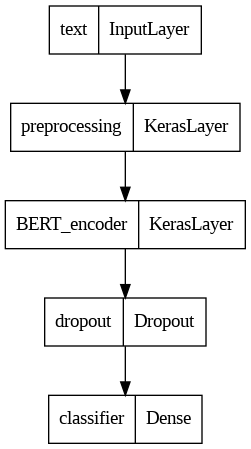

In [ ]:

tf.keras.utils.plot_model(classifier_model)

## Model training



### Loss function



In [14]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]


In [15]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint


# define the checkpoint paths for saving weights after each epoch and the best model
weights_path = 'small_bert/weights_epoch_{epoch:02d}.ckpt'  
best_path = 'small_bert/best_model/best.ckpt'

# use two ModelCheckpoint callbacks to save the weights after each epoch and the best model
# weights_callback = ModelCheckpoint(filepath=weights_path, save_weights_only=True, save_freq='epoch')
best_callback = ModelCheckpoint(filepath=best_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose = 1)



In [19]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
def return_class_weight(train_df):
  answer= {0: 0, 1:0, 2:0}
  labels = [3,4,5]

  for label in labels:
    freq = len(train_df[train_df['rating_label'] == label])/len(train_df)
    answer[label - 3] = 1/(freq*2)

  return answer

freq = return_class_weight(train_df)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs, callbacks = [best_callback],
                               #class_weight = freq
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
576/576 [==============================] - ETA: 0s - loss: 1.5596 - accuracy: 0.4686
Epoch 1: val_accuracy improved from -inf to 0.55054, saving model to small_bert/class_weights/best.ckpt


576/576 [==============================] - 1590s 3s/step - loss: 1.5596 - accuracy: 0.4686 - val_loss: 0.8015 - val_accuracy: 0.5505
Epoch 2/5
576/576 [==============================] - ETA: 0s - loss: 1.3324 - accuracy: 0.5494
Epoch 2: val_accuracy improved from 0.55054 to 0.60065, saving model to small_bert/class_weights/best.ckpt


576/576 [==============================] - 165s 286ms/step - loss: 1.3324 - accuracy: 0.5494 - val_loss: 0.7983 - val_accuracy: 0.6007
Epoch 3/5
576/576 [==============================] - ETA: 0s - loss: 1.1523 - accuracy: 0.6022
Epoch 3: val_accuracy improved from 0.60065 to 0.67983, saving model to small_bert/class_weights/best.ckpt


576/576 [==============================] - 166s 288ms/step - loss: 1.1523 - accuracy: 0.6022 - val_loss: 0.6723 - val_accuracy: 0.6798
Epoch 4/5
576/576 [==============================] - ETA: 0s - loss: 1.0692 - accuracy: 0.6509
Epoch 4: val_accuracy did not improve from 0.67983
576/576 [==============================] - 158s 274ms/step - loss: 1.0692 - accuracy: 0.6509 - val_loss: 0.6674 - val_accuracy: 0.6714
Epoch 5/5
576/576 [==============================] - ETA: 0s - loss: 1.0047 - accuracy: 0.6634
Epoch 5: val_accuracy did not improve from 0.67983
576/576 [==============================] - 161s 279ms/step - loss: 1.0047 - accuracy: 0.6634 - val_loss: 0.6674 - val_accuracy: 0.6714


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6), dpi = 600)
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig("smallbert_normal.png", bbox_inches = 'tight')
plt.show()

In [ ]:
val_dataset = tf.keras.utils.text_dataset_from_directory(
    "/content/drive/MyDrive/Bookpred/Assignment 2/Validation",
    batch_size=batch_size,
    validation_split=None,
    seed=seed)

val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 4610 files belonging to 3 classes.


In [20]:
reloaded_model = build_classifier_model()
reloaded_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
reloaded_model.load_weights(best_path)


# val_prediction = reloaded_model.predict(val_ds)

In [21]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
# Get the class names from the dataset object
class_names = val_dataset.class_names
class_names = [3,4,5]
val_output = []
val_prediction = []
# Print all the labels of all instances in the dataset
for text_batch, label_batch in val_ds:
    # print(label_batch)
    label_names = [class_names[i] for i in label_batch.numpy()]
    y_pred = tf.nn.softmax(reloaded_model.predict(text_batch)).numpy().argmax(axis = 1) + 3
    # print(label_names, len(label_names))
    # print(y_pred, len(y_pred))
    val_output.extend(label_names)
    val_prediction.extend(y_pred)
    # break
print(len(val_output))
print(len(val_prediction))

1/1 [==============================] - 1s 708ms/step
4602
4602


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
import pickle

# Write the list to a file using pickle.dump()
with open('val_prediction_smallbert_cw.pkl', 'wb') as f:
    pickle.dump(val_prediction, f)

# Read the list from the file using pickle.load()
# with open('val_prediction_smallbert_cw.pkl', 'rb') as f:
#     prediction_list = pickle.load(f)

# Write the list to a file using pickle.dump()
with open('val_output_smallbert_cw.pkl', 'wb') as f:
    pickle.dump(val_output, f)

# Read the list from the file using pickle.load()
# with open('val_output_smallbert_cw.pkl', 'rb') as f:
#     output_list = pickle.load(f)


In [ ]:
pd.DataFrame(val_prediction).value_counts()

4    3879
3     672
5      59
dtype: int64

In [ ]:
import pickle

# Write the list to a file using pickle.dump()
with open('val_prediction_smallbert_norm.pkl', 'wb') as f:
    pickle.dump(val_prediction, f)

# Read the list from the file using pickle.load()
# with open('val_prediction_smallbert_cw.pkl', 'rb') as f:
#     prediction_list = pickle.load(f)

# Write the list to a file using pickle.dump()
with open('val_output_smallbert_norm.pkl', 'wb') as f:
    pickle.dump(val_output, f)

# Read the list from the file using pickle.load()
# with open('val_output_smallbert_cw.pkl', 'rb') as f:
#     output_list = pickle.load(f)


In [22]:
test_prediction = reloaded_model.predict(test_ds)

import csv
def read_numpy(test_prediction):
  temp = test_prediction.argmax(axis = -1).astype("float64")
  temp += 3.0
  return temp

def write_csv(prediction):
  with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'rating_label'])
    for i, rating in enumerate(prediction):
        writer.writerow([i+1, rating])

write_csv(read_numpy(test_prediction))
print(pd.DataFrame(read_numpy(test_prediction)).value_counts())

181/181 [==============================] - 529s 3s/step
4.0    5049
3.0     675
5.0      42
dtype: int64
